# $H_2$ Energy Surface with XACC-VQE

To run this problem via docker, run the following from an empty directory

```bash
$ docker run --name xacc-notebook -it -p 8888:8888 -d -v $(pwd):/home/notebooks mccaskey/xacc-all-gate-jupyter-fc26
```

## Setup the Problem

In [1]:
import sys, os
import pyxacc as xacc
import pyxaccvqe as vqe
from pyxaccvqe import PauliOperator
from pyxacc import InstructionParameter
import numpy as np
%matplotlib inline

# Create our Hamiltonian
H = PauliOperator('g0') + PauliOperator({0:'Z'},'g1') + PauliOperator({1:'Z'},'g2') \
	+ PauliOperator({0:'Z',1:'Z'},'g3') + PauliOperator({0:'Y',1:'Y'}, 'g4') \
	+ PauliOperator({0:'X',1:'X'},'g5')

# Read in the coefficient data as a function of R
h2coeffs = np.genfromtxt('h2_hamiltonian_data.csv', delimiter=',', names=['R', 'I', 'Z0', 'Z1', 'Z0Z1', 'Y0Y1', 'X0X1'])

# Construct some lists to detail the name of 
# the variable coefficients, and the columns in the data file
gs = ['g0', 'g1', 'g2', 'g3', 'g4', 'g5']
cols = ['I', 'Z0', 'Z1', 'Z0Z1', 'Y0Y1', 'X0X1']

# Map column name to variable name
gMap = {c:gs[i] for i,c in enumerate(cols)}

# Setup an empty options map, we will add to it for 
# VQE run after straight diagonalization run
# NOTE that default task is vqe-diagonalize and 
# default backend is Eigen. 
vqeOptions = {} 

print('Hamiltonian = ', H)

Hamiltonian =  (1,0) g0 + (1,0) g2 Z1 + (1,0) g3 Z0 Z1 + (1,0) g4 Y0 Y1 + (1,0) g1 Z0 + (1,0) g5 X0 X1


## Compute Energy Surface using Eigen Diagonalization

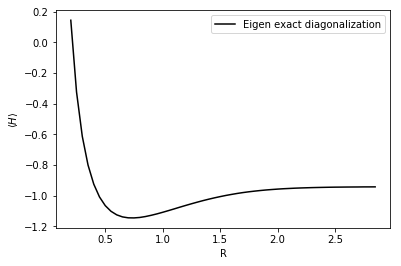

[nan, 0.14421033191099078, -0.3239392452849163, -0.6129745446098808, -0.8005102614889511, -0.9252596050468844, -1.0090090168725934, -1.0653917810254399, -1.1023261930074157, -1.1255942623603343, -1.138944744265075, -1.1449602744086183, -1.145599124123644, -1.1426780822372007, -1.1366267416569642, -1.1285566250529924, -1.1192976811310633, -1.108916728018456, -1.0980199958810752, -1.08683514089159, -1.0753721313653328, -1.0642391354996807, -1.0534428198670482, -1.0429960772068512, -1.032929756778952, -1.0235800048376693, -1.0148230772539004, -1.0066547782599162, -0.9990246022682364, -0.9922259545720717, -0.9858045727517245, -0.9801467267992977, -0.9751555229656769, -0.9708068577346939, -0.9668306578179781, -0.963298281781869, -0.9603564069640453, -0.9576146716412125, -0.9552900453924044, -0.9534512612030396, -0.9516035927916376, -0.9501833680820638, -0.949015844628429, -0.9478716054742458, -0.9469815432620154, -0.9462192610724477, -0.9454641240197313, -0.9448869305338706, -0.944566266635

In [4]:
energies = []
# Loop over all R
for i, r in enumerate(h2coeffs['R']):
    
    # Construct the variable to coeff map
    varMap = {gMap[k]:h2coeffs[k][i] for k in cols}

    # Evaluate our Hamiltonian
    Heval = H.eval(varMap)

    # Execute - this diagonalizes the Hamiltonian 
    # and returns lowest eigenvalue
    e = vqe.execute(Heval, **vqeOptions).energy
    energies.append(e)

import matplotlib.pyplot as plt
plt.xlabel(r'R')
plt.ylabel(r'$\langle H\rangle$')
plt.plot(h2coeffs['R'], energies, color='k', label='Eigen exact diagonalization')
plt.legend()
plt.show()
print(energies)

## Compute Energy Surface with VQE using TNQVM

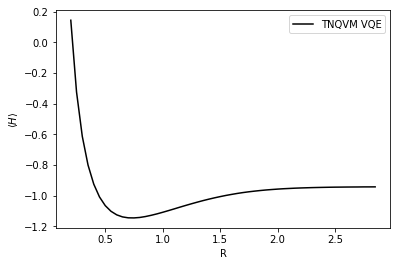

In [6]:
# Create the State Preparation Circuit for our VQE Run
statePrep = xacc.gate.GateFunction('statePrep', ['theta'])
statePrep.add(xacc.gate.create('Rx',[0],[np.pi]))
statePrep.add(xacc.gate.create('Ry',[1],[np.pi/2.]))
statePrep.add(xacc.gate.create('Rx',[0],[7.8539752]))
statePrep.add(xacc.gate.create('CNOT',[1,0]))
statePrep.add(xacc.gate.create('Rz',[0],['theta']))
statePrep.add(xacc.gate.create('CNOT',[1,0]))
statePrep.add(xacc.gate.create('Ry',[1],[7.8539752]))
statePrep.add(xacc.gate.create('Rx',[0],[np.pi/2.]))

vqeOptions = {'task':'vqe', 'ansatz':statePrep} 

vqeenergies = []
# Loop over all R
for i, r in enumerate(h2coeffs['R']):
    
    # Construct the variable to coeff map
    varMap = {gMap[k]:h2coeffs[k][i] for k in cols}

    # Evaluate our Hamiltonian
    Heval = H.eval(varMap)

    # Execute - this diagonalizes the Hamiltonian 
    # and returns lowest eigenvalue
    e = vqe.execute(Heval, **vqeOptions).energy
    vqeenergies.append(e)

import matplotlib.pyplot as plt
plt.xlabel(r'R')
plt.ylabel(r'$\langle H\rangle$')
plt.plot(h2coeffs['R'], vqeenergies, color='k', label='TNQVM VQE')
plt.legend()
plt.show()

## Finalize the Framework

In [10]:
xacc.Finalize()